## FFT 1D with a regular holo phase patttern

 author : Sylvie Dagoret-Campagne
- aflilation IJCLab/IN2P3/CNRS
- creation date 2025-01-14
- last update : 2025-01-14 
- last update : 2024-01-15 : Save formula
- doc on FFT : https://numpy.org/doc/2.0/reference/generated/numpy.fft.fft.html
- conda environnement : poppy_conda_py312 (on my macbook)
- install poppy : https://poppy-optics.readthedocs.io/en/latest/
- install rise in jupyterlab to see the slides : https://github.com/jupyterlab-contrib/rise
- install pandoc for documentation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.integrate import quad

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.titlesize'] =  24
mpl.rcParams['axes.labelsize'] =  20
mpl.rcParams['lines.markersize'] =  10
mpl.rcParams['xtick.labelsize'] =  16
mpl.rcParams['ytick.labelsize'] = 16

## Introduction

### Diffraction of a parallel beam by a 1D aperture $x_1$ seen on a screen at $x_0$ 

We approximate the diffraction by an optical element with the 1D approximation, with the $x$ axis as the transverse coordinalte and the $z$ axis the wave propagation axis.
Taking the formula from the Goodman book we get the formula:

- in Fresnel approximation (spherical wave $\rightarrow$ quadratic terms in propagation term $\frac{e^{ikr_{01}}}{j\lambda z}$~:$z^3 \gg \frac{\pi}{4\lambda}\left(x_0-x_1\right)^4|_{max} $:
$$
U(x_0) = \frac{exp(jkz)}{jkz} \exp\left(j \frac{k}{2z}x_0^2 \right) \int \int \left\{ U(x_1) \exp\left(  j \frac{k}{2z}x_1^2\right)\right\} \times \exp \left\{ -j \frac{2 \pi}{\lambda z}x_0\cdot x_1
\right\}dx_1 
$$
- in Fraunhofer approximation $ z \gg \frac{k(x_1^2+y_1)}{2}|_{max}$:
$$
U(x_0) = \frac{exp(jkz)}{jkz} \exp\left(j \frac{k}{2z}x_0^2 \right) \int \int  U(x_1)  \times \exp \left\{ -j \frac{2 \pi}{\lambda z}x_0\cdot x_1
\right\}dx_1 
$$
- The Fraunhofer approximation solution is proportional to the Fourier transform of $U(x_1)$ at frequency $f_X = \frac{x_0}{\lambda z} = \frac{\tan \alpha}{\lambda }$
- The Fresnel approximation solution is proportional to the Fourier transform of $\left \{ U(x_1) \cdot \exp\left(  j \frac{k}{2z}x_1^2\right) \right\}$ at frequency $f_X = \frac{x_0}{\lambda z} = \frac{\tan \alpha}{\lambda }$
- $ \alpha$ is the incident angle on the focal line  in the $(X-Z)$ plane.

### Transform the parallel beam into a converging beam

- thin lens of focal length $\phi$ with a transmission function (depending on lens depth $\Delta_0$ and refractive index $n$):
$$
U_l(x) = \exp(j k\Delta_0 n) \cdot \exp(-j \frac{k}{2\phi}x^2)
$$
- When a lens (or mirror) transform a parallel beam into a converging beam at the location of an object and have a screen at the focal plane, the $\exp \left(j \frac{k}{2z}x_1^2 \right)$ is compensated by the lens term $\exp(-j \frac{k}{2\phi}x^2)$
- Thus a  converging lens (or mirror) transform a parallel beam Fresnel diffraction into a Fraunhofer diffraction, provided $z=\phi$.
$$
U(x_\phi) = \frac{exp(jk\phi)}{jk\phi} \exp\left(j \frac{k}{2\phi}x_{\phi}^2 \right) \int \int U(x)\cdot P(x) \times \exp 
\left\{ -j \frac{2 \pi}{\lambda \phi}x_\phi x\right\} dx 
$$

### The pupil function of the lens
$$
P(x) = \left\{ \begin{array}{c} 1 \;\; r < D/2 \\ 0 \;\;r > D/2 \end{array} \right.
$$

where $r=|x|$ and $D$ is the lens diameter.

## Function tools

In [3]:
def convert_angle_to_0_2pi_interval(angle):
    new_angle = np.arctan2(np.sin(angle), np.cos(angle))
    new_angle = np.where(new_angle < 0,np.abs(new_angle) + 2 * (np.pi - np.abs(new_angle)),new_angle)
    return new_angle

In [4]:
convert_angle_to_0_2pi_interval(-np.pi/4)

array(5.49778714)

In [5]:
def convert_angle_to_mpi_ppi_interval(angle):
    new_angle = convert_angle_to_0_2pi_interval(angle)
    new_angle = np.where(new_angle > np.pi, new_angle - 2*np.pi,new_angle)

    return new_angle

### Auxtel Configuration

In [6]:
# wavelength in m
wl = 0.5e-6
# pixel scale
# 10 microns pixel , 105 microns per arcsec
pix_scale = 10.0/105.0 # arcsec per pixel
fov_arcsec = 5.0 # must restrict the FOV in focl plane to avoid aliasing
# diameter in m
D = 1.2
Fnum = 18
# focal length
FL = D*Fnum
# Dccd
Dccd = 180e-3
# beam radius at object positon
beam_radius_m =  D/2/FL*Dccd
beam_radius_mm =  D/2/FL*Dccd*1000

In [7]:
beam_radius_mm

5.0

### Diffraction Pattern

In [8]:
Neff = 150
xmin = -0.05
xmax = 0.05
dxt = xmax-xmin
a = 1/Neff

### Hologram recording

In [9]:
lambda_R = 0.639e-3 #mm
dR = 20.0
DR = dR/lambda_R/Neff

## Optical depth pattern function

The interference of the two point sources $A,B$ on the hologram emulsion is described
by the following formula
$$
U_{tot} = U_a + U_b = a\frac{e^{ikr_{AM}}}{r_{AM}} + b\frac{e^{ikr_{BM}}}{r_{BM}}
$$
where $a,b$ are the complex amplitudes of the sources at their emission location and the exponential terms $\frac{e^{ikr}}{r}$ describe the outgoing spherical waves.

- If we approximate $\frac{1}{r_{AM}} \simeq \frac{1}{r_{BM}} \simeq \frac{1}{D_R}$,
- We redefine (a,b) by a relative phase shift between the souces $\Delta \psi$ and a relative positive amplitudes (by definition as the phase shift account for negative)
  $\cos \beta, \sin \beta$ such $0 \le \beta \le \frac{\pi}{4}$:
$$
\begin{array}{ccc}
a & = &a_0 \cos \beta e^{-i \frac{\Delta \psi}{2}} \\
b & = & a_0  \sin\beta  e^{i \frac{\Delta \psi}{2}}
\end{array}
$$

Redfining the coordinate in the recording plane $w$ by $x$:

$$
\begin{array}{ccc}
D_{AM}^2 & = & D_R^2 + \left( \frac{d_R}{2}\right)^2 + l^2 + d_R\cdot x \\
D_{BM}^2 & = & D_R^2 + \left( \frac{d_R}{2}\right)^2 + l^2 - d_R \cdot x 
\end{array}
$$

If we approximate $D_R \gg d_R,l,x$:

$$
\begin{array}{ccc}
D_{AM} & = & D_R + \frac{\left( \frac{d_R}{2}\right)^2 + l^2 + d_R\cdot x }{2D_R}\\
D_{BM} & = & D_R + \frac{\left( \frac{d_R}{2}\right)^2 + l^2 - d_R \cdot x }{2D_R}
\end{array}
$$


### Pattern recorded on emulsion

$$
I = \| U_{tot} \|^2 \propto 1 +  \sin 2\beta \cdot \cos \left( k\frac{d_R\cdot x}{D_R}  -  \Delta \psi \right) =  1 +  \sin 2\beta \cdot \cos \left( 2\pi \frac{d_R\cdot x}{\lambda_F D_R}  -  \Delta \psi \right) 
$$

The periodicity is:

$$
\Delta x = \frac{\lambda_R D_R}{d_R}
$$

and the interference contrast $0 <C< 1$ is :

$ C = \frac{I_{max} - I_{min}}{I_{max} + I_{min}} = \sin 2\beta$

- Note if the two sources have the same amplitudes within a phase shift the contrast is maximal.

In [10]:
delta_x = (DR*lambda_R/dR)
print(f"the periodicity of the lines is {delta_x:.4f} mm and Neff = {1/delta_x}")

the periodicity of the lines is 0.0067 mm and Neff = 150.0


## Transmission functions

In [11]:
def set_beam_aperture(x,radius = beam_radius_mm):
    """
    """
    a = np.where(np.logical_or(x<-radius,x>radius),0.,1.)
    return a

In [12]:
def set_holo_pattern_debug(x,opticalelement_nblines_permm=Neff,xshift=0,contrast=0.5):
    """
    Generate a square pattern of transmission.
    x in mm
    xshift : between -1,1
    contrast : 
    """
    a = 1/opticalelement_nblines_permm
    x = (x + xshift*a/2)/a
    y = (1+contrast*np.cos(2*np.pi*x))/2.
    return y

(0.0, 1.0)

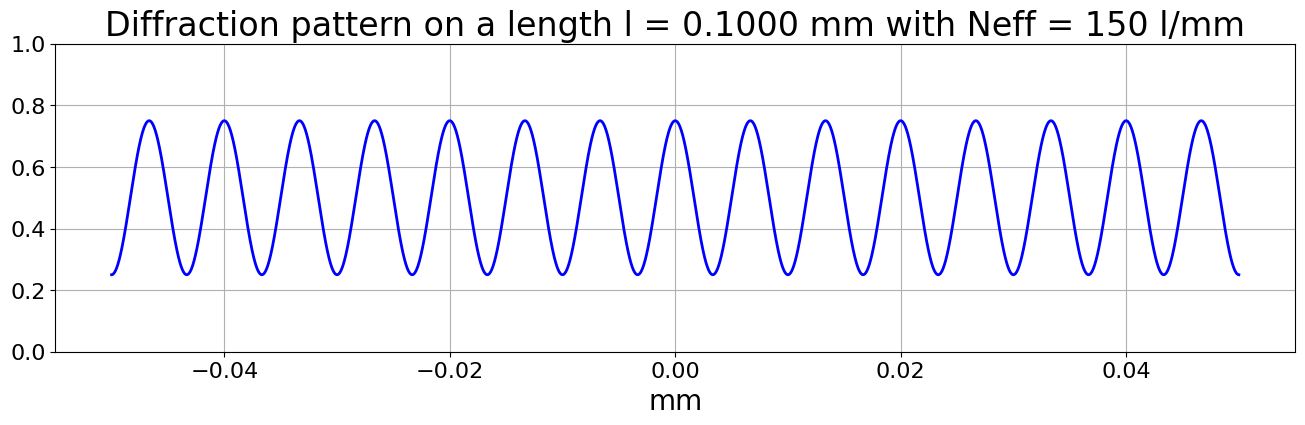

In [13]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
x = np.linspace(-.05,0.05,5000)
y = set_holo_pattern_debug(x,xshift=0)
ax.plot(x,y,'b-')
ax.grid()
ax.set_title(f"Diffraction pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax.set_xlabel("mm")
ax.set_ylim(0.,1.)

In [14]:
def set_holo_phase_debug(x,opticalelement_nblines_permm=Neff,xshift=0,contrast=0.5):
    """
    Generate a square phase pattern of transmission including the pupil function.
    x in mm
    xshift : between -1,1
    """
    a = 1/opticalelement_nblines_permm
    #x = x + xshift*a/2
    
    #r = np.exp(1j*np.pi*np.rint(x/a-0.25 - np.floor(x/a-0.25))-0.5)
    r = np.exp(1j*np.pi* set_holo_pattern_debug(x,opticalelement_nblines_permm=Neff,xshift=xshift,contrast=contrast))
    rcut = np.where(np.logical_or(x<-beam_radius_mm,x>beam_radius_mm),0,r)
    return rcut

### Do the control

In [15]:
x = np.linspace(-.05,0.05,100000)
yc = set_holo_phase_debug(x,opticalelement_nblines_permm=Neff,xshift=0,contrast=1)

Text(0.5, 0, ' x (mm)')

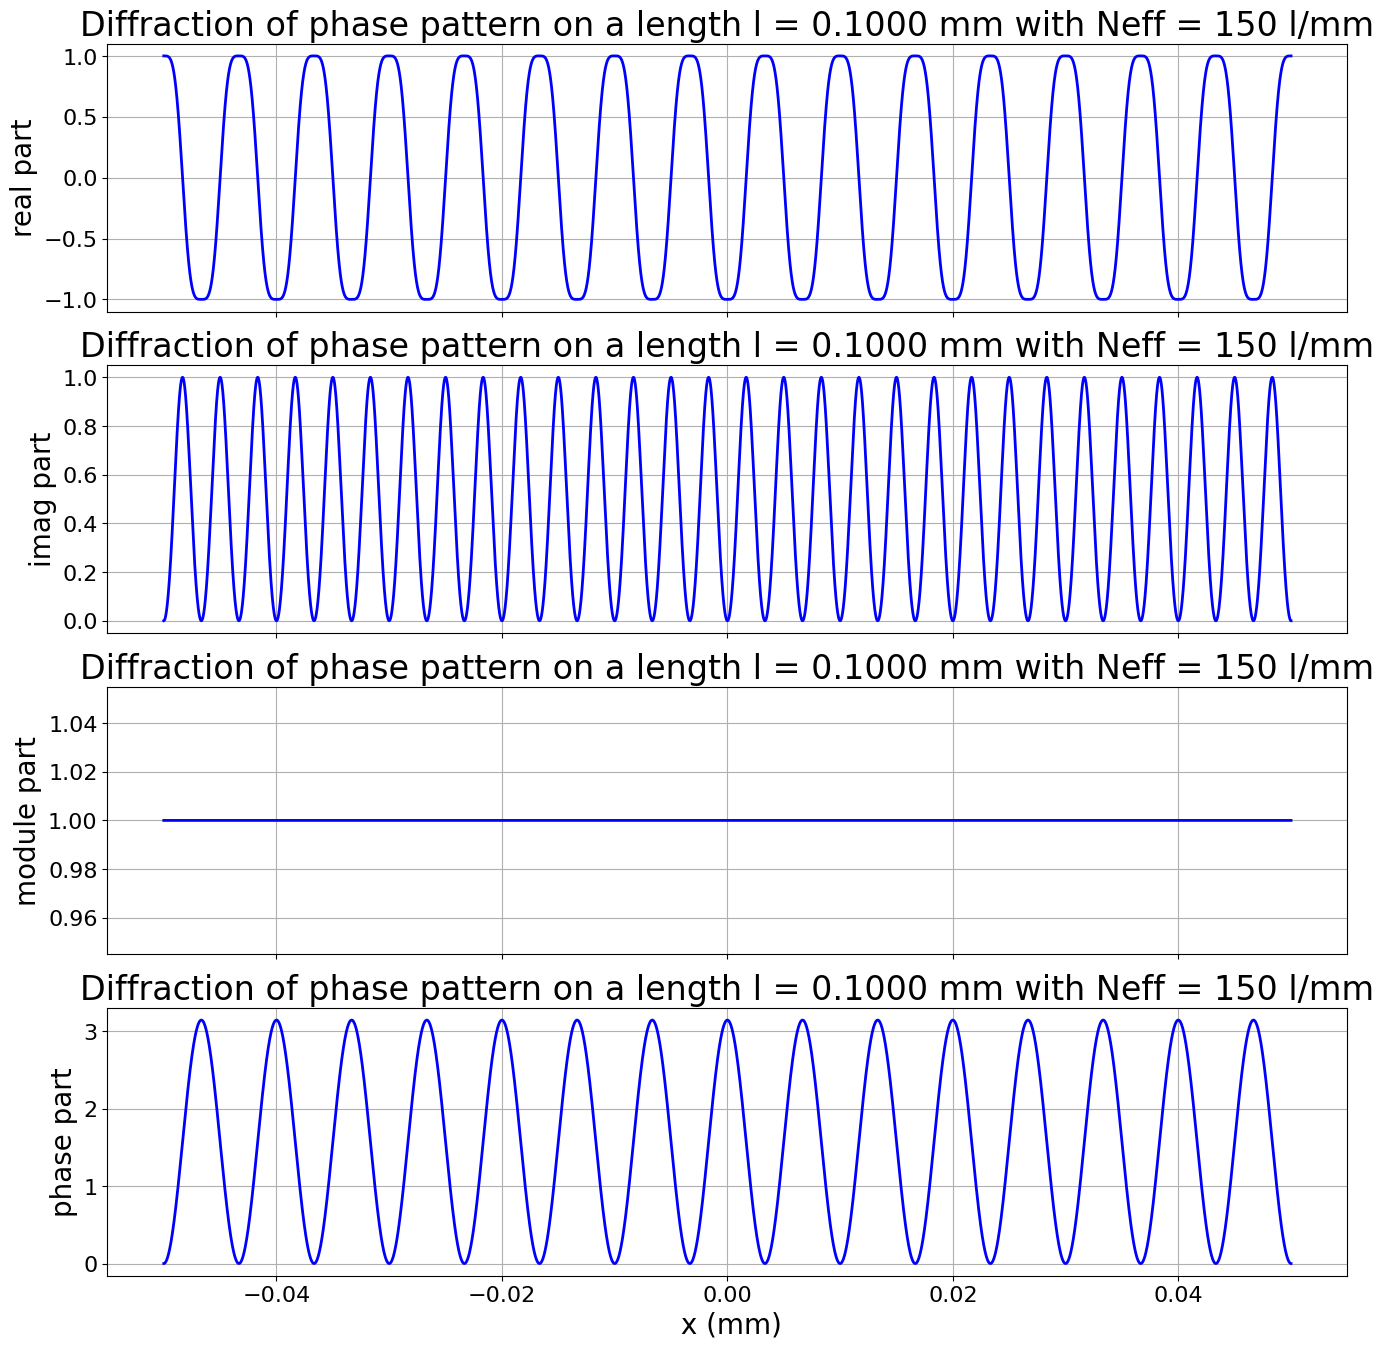

In [16]:
# check the generated pattern
fig,axs = plt.subplots(4,1,figsize=(16,16),sharex=True)
ax1,ax2,ax3,ax4 = axs.flatten()

ax1.plot(x,yc.real,'b-',label="real part")
ax1.grid()
ax1.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax1.set_ylabel("real part")

ax2.plot(x,yc.imag,'b-',label="imag part")
ax2.grid()
ax2.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax2.set_ylabel("imag part")

ax3.plot(x,np.abs(yc),'b-',label="module part")
ax3.grid()
ax3.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax3.set_ylabel("module part")


ax4.plot(x,np.angle(yc),'b-',label="phase part")
ax4.grid()
ax4.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax4.set_ylabel("phase part")

ax4.set_xlabel(" x (mm)")

### Parameters of the FFT

In [17]:
#Nb = 10001 ## Too small for sampling
Nb = 40001 ## Too small for sampling
padding_factor = 1.5

In [18]:
# x in units of mm
xe = np.linspace(-beam_radius_mm*padding_factor,+beam_radius_mm*padding_factor,Nb)
dxe = np.diff(xe).mean()
fe = 1/dxe
fmax = fe/2

In [19]:
print(f"Sampling distance dxe = {dxe} mm ")
print(f"Sampling frequency fe = {fe:.3f} mm -1")
print(f"Max signal requency fmax = {fmax:.3f} mm -1 before aliasing")
print(f"Beam radius = {beam_radius_mm} mm")
print(f"Beam radius frequency = {1/beam_radius_mm} mm-1")

Sampling distance dxe = 0.000375 mm 
Sampling frequency fe = 2666.667 mm -1
Max signal requency fmax = 1333.333 mm -1 before aliasing
Beam radius = 5.0 mm
Beam radius frequency = 0.2 mm-1


## Compute inputs for the FFT

### Pattern shift

In [20]:
XSHIFT = 0

### Input for the aperture

In [21]:
ap = set_beam_aperture(xe)

### Input for the pattern

In [22]:
ye = set_holo_pattern_debug(xe,xshift=XSHIFT)
# set padding on the borders
r = np.where(np.logical_or(xe<-beam_radius_mm,xe>beam_radius_mm),0,ye)

## Plots the patterns

### Aperture pattern

Text(0.5, 0, 'mm')

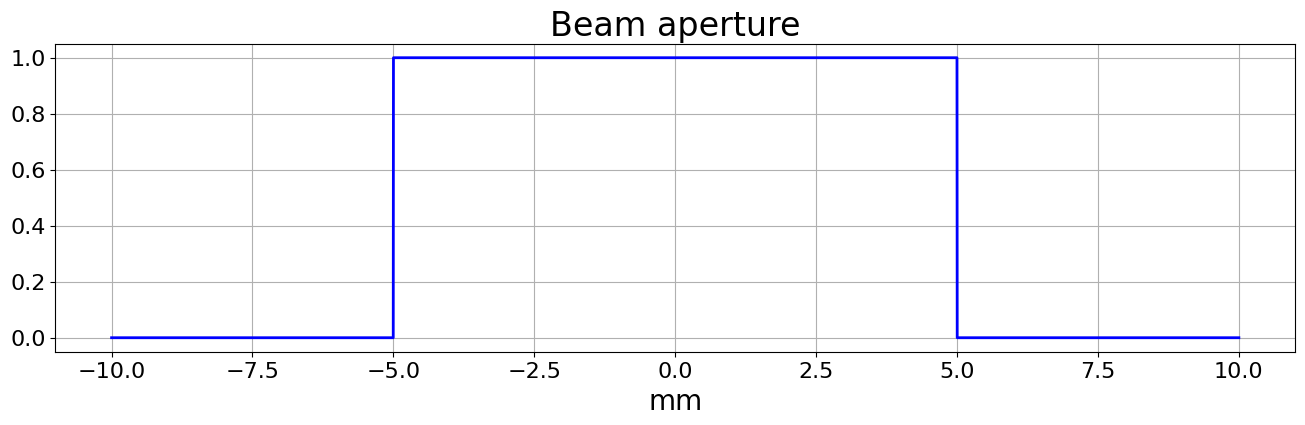

In [23]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
x = np.linspace(-10.,10.,5000)
y = set_beam_aperture(x)
ax.plot(x,y,'b-')
ax.grid()
ax.set_title(f"Beam aperture")
ax.set_xlabel("mm")

## Compute the FFT

### FFT for the beam with the aperture only

In [24]:
spa = np.fft.fft(ap)
# the frequency in units of mm^-1

# do a deep copy
freqa = np.array(np.fft.fftfreq(ap.shape[-1], d=dxe))
reala = np.array(spa.real)
imaga = np.array(spa.imag)
modulea = np.array(np.abs(spa))
phasea = np.array(np.angle(spa))

In [25]:
freqa = np.fft.fftshift(freqa)
reala = np.fft.fftshift(reala)
imaga = np.fft.fftshift(imaga)
modulea = np.fft.fftshift(modulea)
phasea = np.fft.fftshift(phasea)
N = len(freqa)

#### Plot FFT components
- a) real part
- b) imaginary part
- c) module
- d) phase

Text(0, 0.5, 'FFT phase')

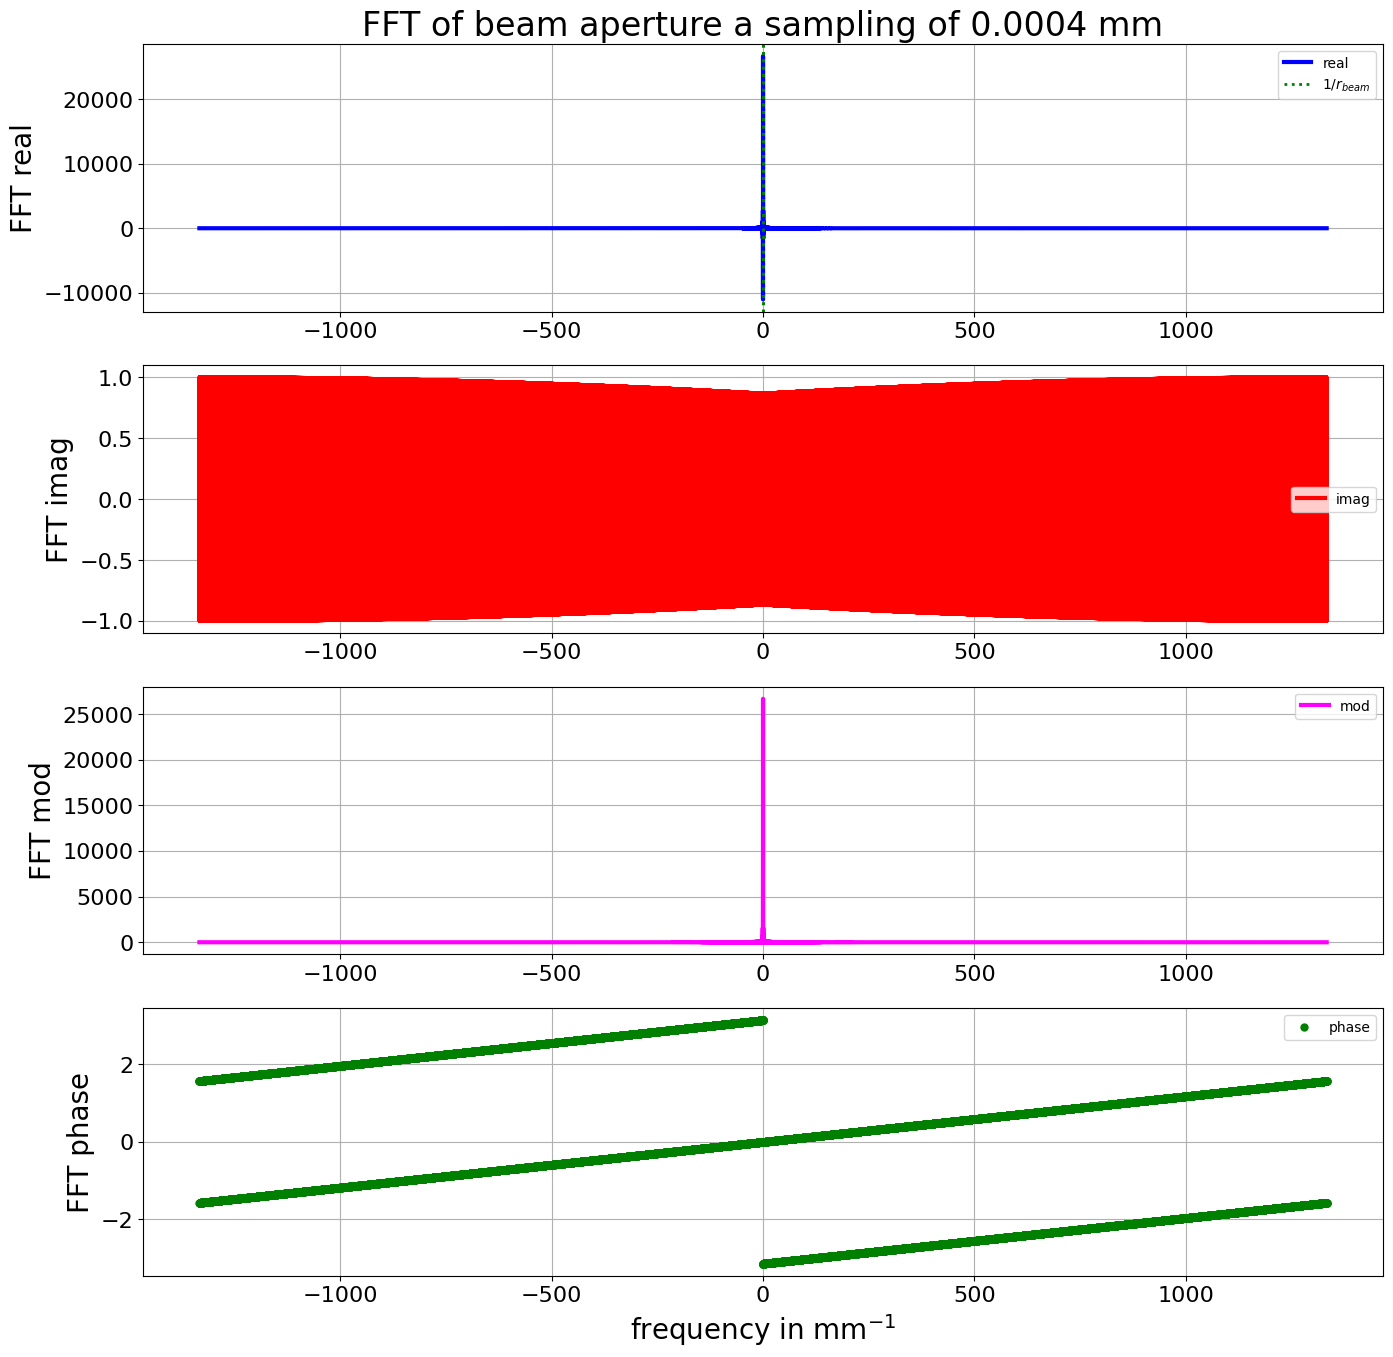

In [26]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(16,16),sharex=False)
ax1.plot(freqa, reala, 'b',lw=3, label = "real")
ax1.grid()
ax1.set_title(f"FFT of beam aperture a sampling of {dxe:.4f} mm")
ax1.axvline(x=1/beam_radius_mm,c="g",ls=":",label="$1/r_{beam}$")
ax1.axvline(x=-1/beam_radius_mm,c="g",ls=":")
ax2.plot(freqa, imaga, 'r',lw=3, label = "imag")
ax2.grid()
ax3.plot(freqa, modulea, c='magenta',lw=3, label = "mod")
ax3.grid()
ax4.plot(freqa, convert_angle_to_mpi_ppi_interval(phasea),'.g',lw=3, label = "phase")
ax4.grid()
ax4.set_xlabel("frequency in mm$^{-1}$")
ax1.legend()
ax1.set_ylabel("FFT real")
ax2.legend()
ax2.set_ylabel("FFT imag")
ax3.legend()
ax3.set_ylabel("FFT mod")
ax4.legend()
ax4.set_ylabel("FFT phase")

#### Plot the FFT coefficients in the aperture diffractive region

In [27]:
print(f"Beam radius = {beam_radius_mm} mm")
print(f"Beam radius frequency = {1/beam_radius_mm} mm-1")

Beam radius = 5.0 mm
Beam radius frequency = 0.2 mm-1


Text(0.5, 1.0, 'First Fourier components')

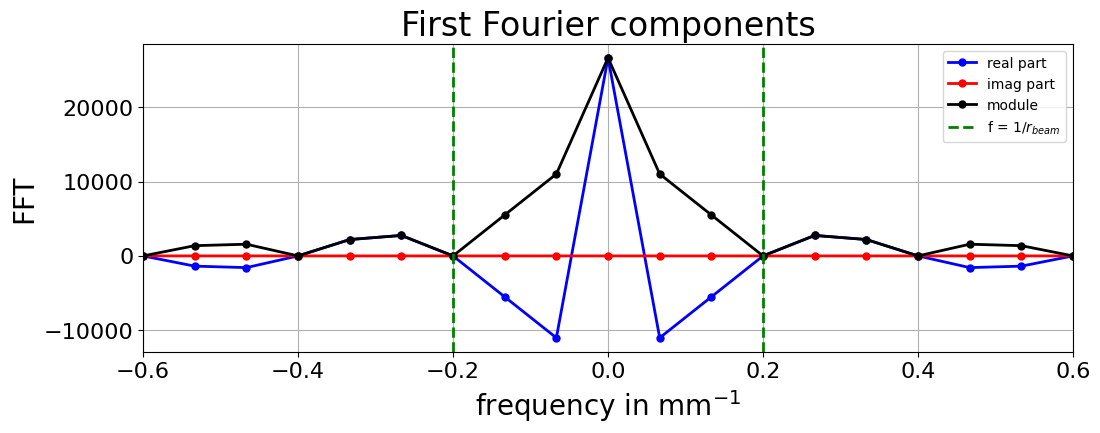

In [28]:
fig,ax = plt.subplots(1,1,figsize=(12,4))

DF = 3*1/beam_radius_mm

ax.plot(freqa,reala,marker=".",c="b",label="real part")
ax.plot(freqa,imaga,marker=".",c="r",label="imag part")
ax.plot(freqa,modulea,marker=".",c="k",label="module")
ax.set_ylabel("FFT")
ax.set_xlim(-DF,DF)

ax.set_xlabel("frequency in mm$^{-1}$")
ax.axvline(x=1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax.grid()
ax.legend()
ax.set_title("First Fourier components")

#### First Fourier components 

Text(0.5, 0.98, 'First coefficients of FFT for beam aperture')

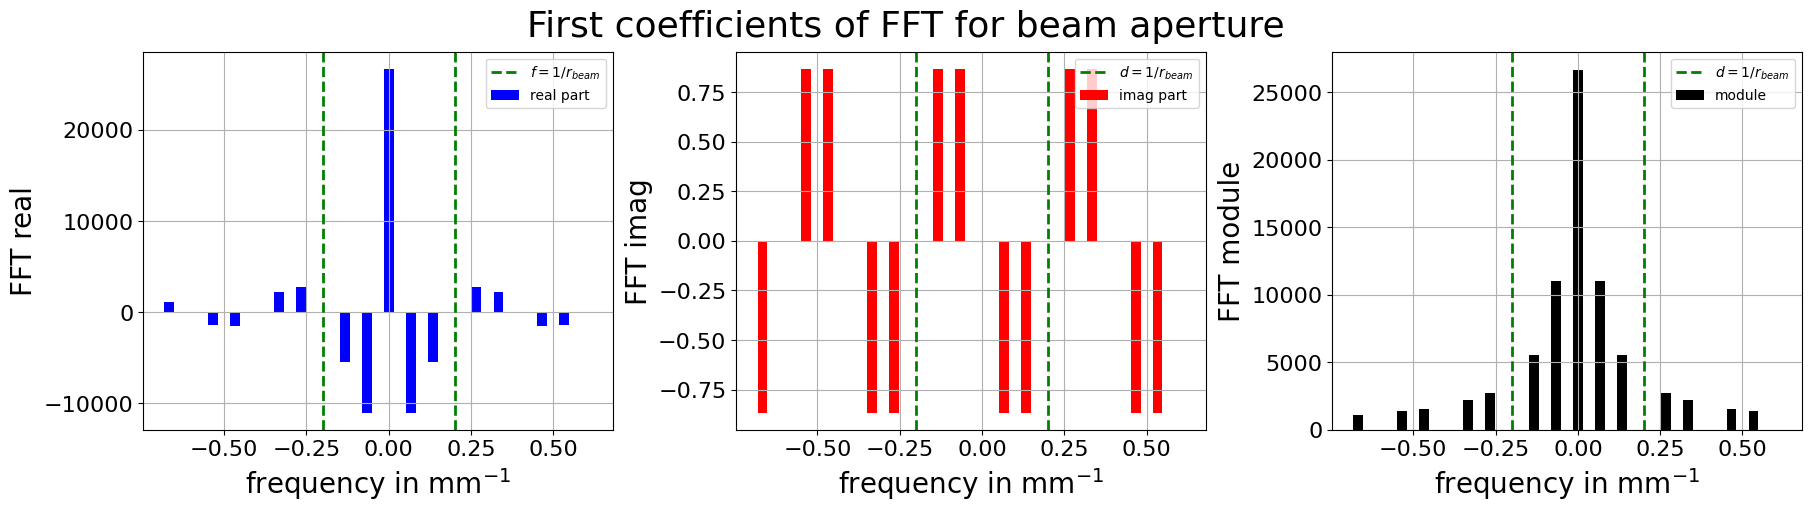

In [29]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5),sharex=True,layout="constrained")
ax1.bar(freqa[N//2-10:N//2+10],reala[N//2-10:N//2+10],width=0.03,facecolor="b",label="real part")
ax2.bar(freqa[N//2-10:N//2+10],imaga[N//2-10:N//2+10],width=0.03,facecolor="r",label="imag part")
ax3.bar(freqa[N//2-10:N//2+10],modulea[N//2-10:N//2+10],width=0.03,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")
ax1.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle("First coefficients of FFT for beam aperture",fontsize=26)

## FFT for the beam with the optical element in place : Phase

**NOTICE :In order that the two level of $ye$ to be in opposite phase, we must have:**
- $phase = \pi$ when ye =1
- $phase = 0$ when ye =0

**MUST BE CONFIRMED**

### Transmission generated by optical element

In [30]:
#r = ap*np.exp(1j*np.pi*ye)

# NOTICE HERE I HAVE TO MULTIPLY BY 1j*pi and not 2j*pi
# ?????
#r = ap*np.exp(1j*np.pi*ye) # Old way to calculate
r = set_holo_phase_debug(xe,opticalelement_nblines_permm=Neff,xshift=0) # new way

(-0.05, 0.05)

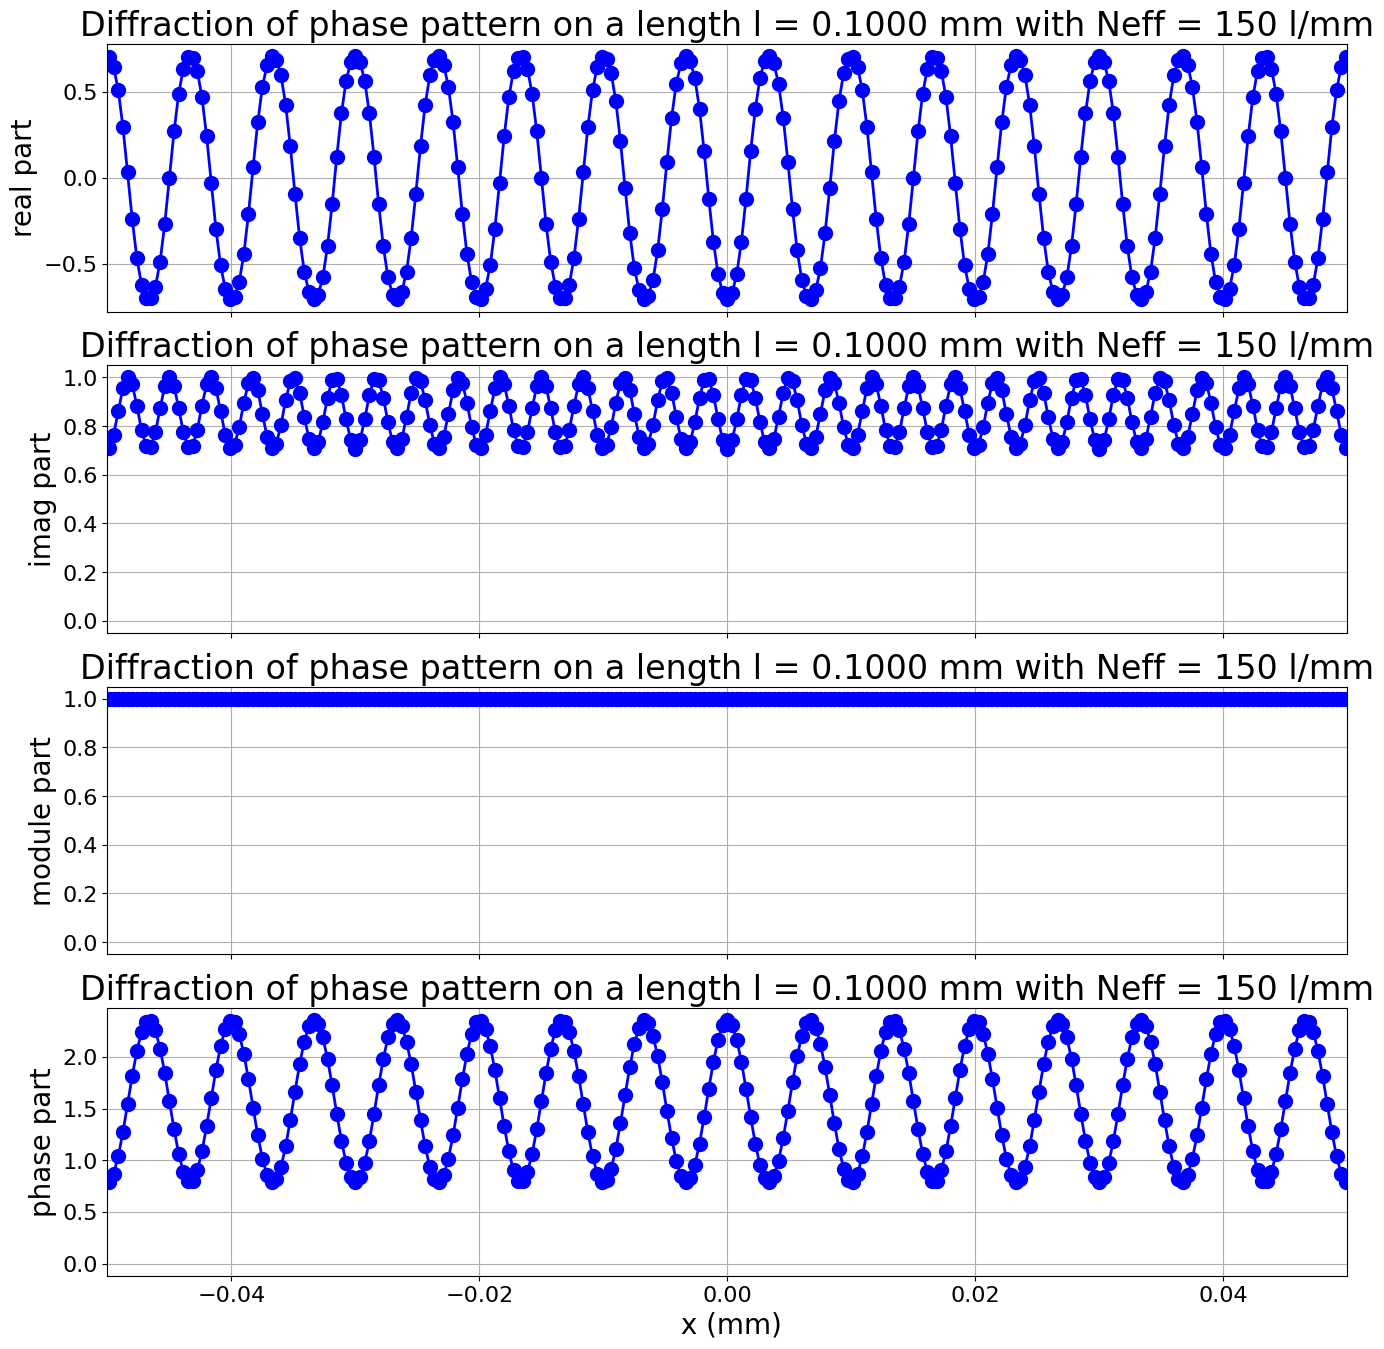

In [63]:
# check the generated pattern
fig,axs = plt.subplots(4,1,figsize=(16,16),sharex=True)
ax1,ax2,ax3,ax4 = axs.flatten()

ax1.plot(xe,r.real,'o-b',label="real part")
ax1.grid()
ax1.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax1.set_ylabel("real part")

ax2.plot(xe,r.imag,'o-b',label="imag part")
ax2.grid()
ax2.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax2.set_ylabel("imag part")

ax3.plot(xe,np.abs(r),'o-b',label="module part")
ax3.grid()
ax3.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax3.set_ylabel("module part")


ax4.plot(xe,np.angle(r),'o-b',label="phase part")
ax4.grid()
ax4.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax4.set_ylabel("phase part")


ax4.set_xlabel(" x (mm)")

# choose one of the boundaries to check
ax1.set_xlim(-0.05,0.05)


#### FFT with numpy

In [32]:
sp = np.fft.fft(r)
# the frequency in units of mm^-1
# do a deep copy
freq = np.array(np.fft.fftfreq(r.shape[-1], d=dxe))
real = np.array(sp.real)
imag = np.array(sp.imag)
module = np.array(np.abs(sp))
phase = np.array(np.angle(sp))

In [33]:
freq = np.fft.fftshift(freq)
real = np.fft.fftshift(real)
imag = np.fft.fftshift(imag)
module = np.fft.fftshift(module)
phase = np.fft.fftshift(phase)
N = len(freq)

### Order 1 and order 2 components

In [34]:
# compute the spatial frequency where the order 1 and 2 are
f_order1 = Neff
f_order2 = 2*Neff

In [35]:
def plot_orders_regions(ax,df=1/beam_radius_mm):
    """
    
    """

    ax.axvline(x=df,c="pink",ls=":",label="order 0")
    ax.axvline(x=-df,c="pink",ls=":")

    if f_order1 < fmax:
        ax.axvline(x=f_order1+df,ls = ":",color="purple",label="order 1")
        ax.axvline(x=f_order1-df,ls = ":",color="purple")
        ax.axvline(x=-f_order1-df,ls = ":",color="purple")
        ax.axvline(x=-f_order1+df,ls = ":",color="purple")
       
    if f_order2 < fmax:
        ax.axvline(x=f_order2+df,ls = ":",color="cyan",label="order 2")
        ax.axvline(x=f_order2-df,ls = ":",color="cyan")
        ax.axvline(x= - f_order2-df,ls = ":",color="cyan")
        ax.axvline(x= - f_order2+df,ls = ":",color="cyan")

#### Plot FFT components
- a) real part
- b) imaginary part
- c) module
- d) phase

Text(0, 0.5, 'FFT phase')

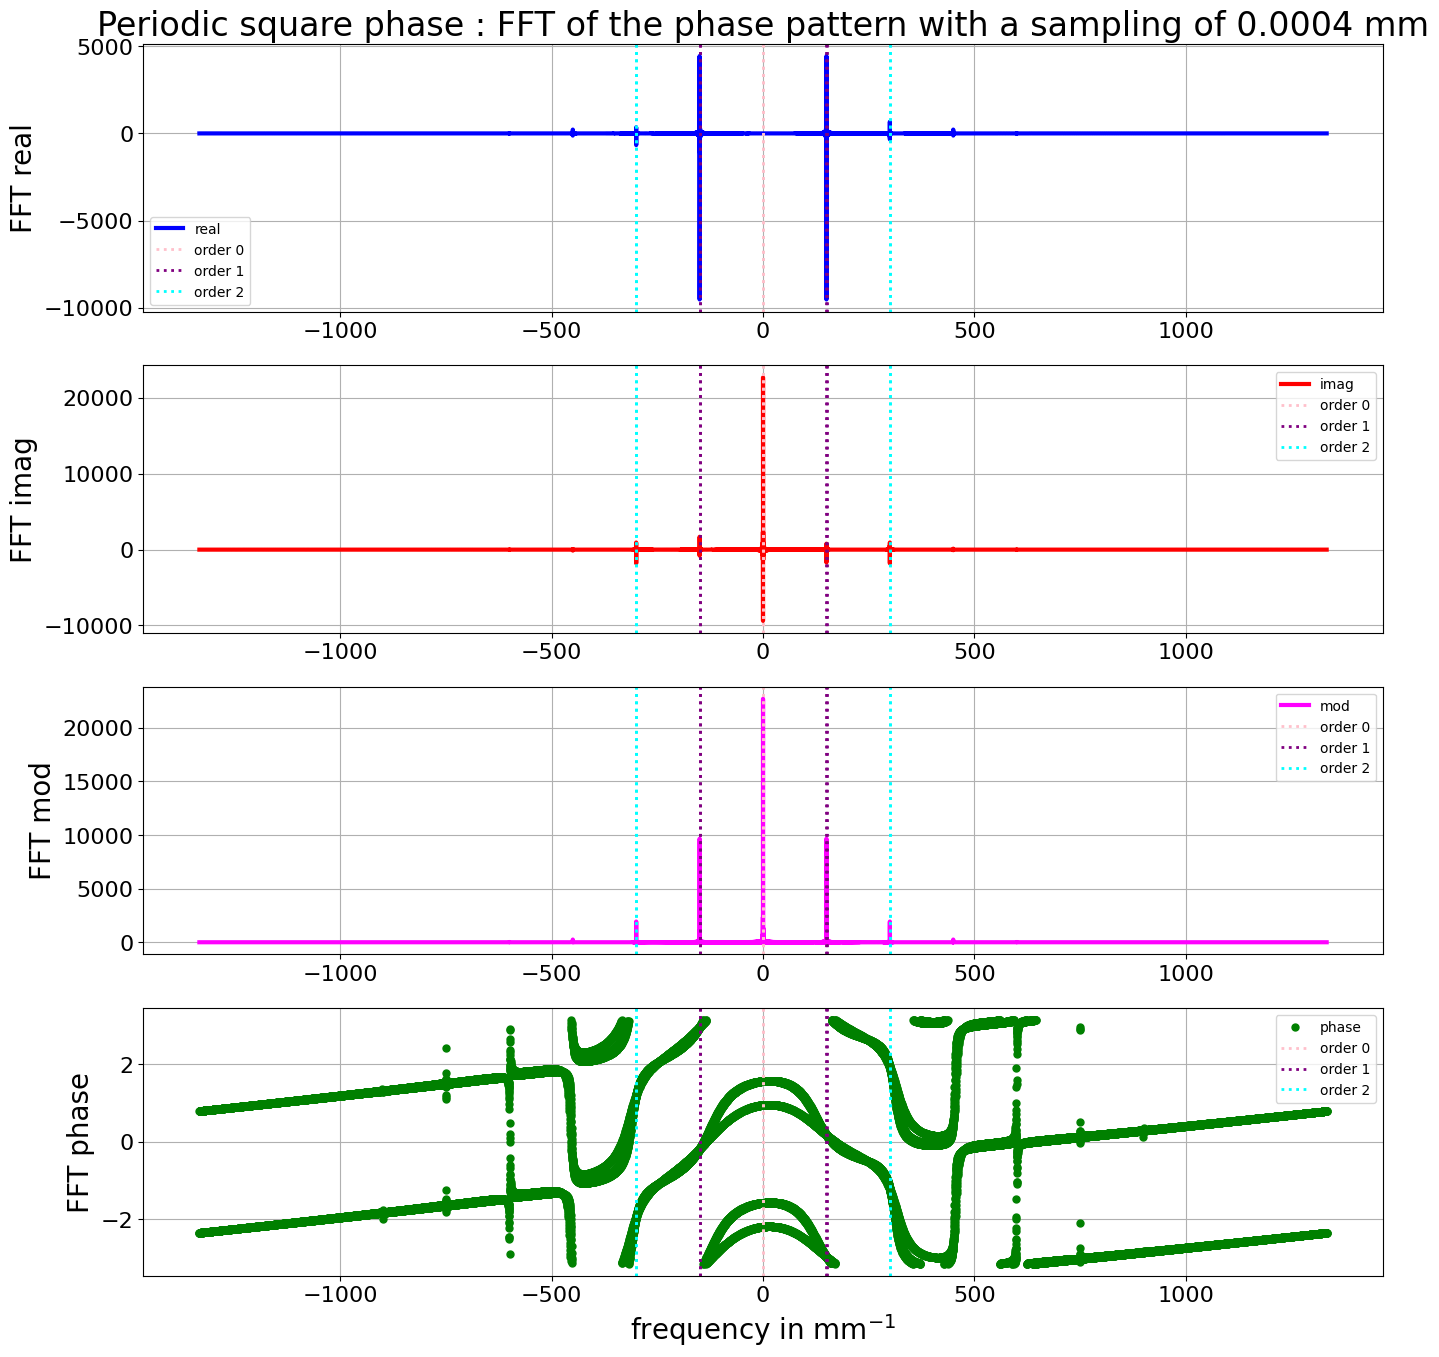

In [36]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(16,16),sharex=False)

ax1.plot(freq, real, 'b',lw=3, label = "real")
ax1.grid()
ax1.set_title(f"Periodic square phase : FFT of the phase pattern with a sampling of {dxe:.4f} mm")
plot_orders_regions(ax1)

ax2.plot(freq, imag, 'r',lw=3, label = "imag")
plot_orders_regions(ax2)
ax2.grid()

ax3.plot(freq, module, c='magenta',lw=3, label = "mod")
plot_orders_regions(ax3)
ax3.grid()

ax4.plot(freq, convert_angle_to_mpi_ppi_interval(phase),'.g',lw=3, label = "phase")
plot_orders_regions(ax4)
ax4.grid()
ax4.set_xlabel("frequency in mm$^{-1}$")


ax1.legend()
ax1.set_ylabel("FFT real")
ax2.legend()
ax2.set_ylabel("FFT imag")
ax3.legend()
ax3.set_ylabel("FFT mod")
ax4.legend()
ax4.set_ylabel("FFT phase")

#### Plot the FFT coefficients in the aperture diffractive region

In [37]:
print(f"Beam radius = {beam_radius_mm} mm")
print(f"Beam radius frequency = {1/beam_radius_mm} mm-1")

Beam radius = 5.0 mm
Beam radius frequency = 0.2 mm-1


In the following plot, we see almost zero imaginary part due to the fact the function is pair.

Text(0.5, 1.0, 'Periodic square Phase : First Fourier components (order -1)')

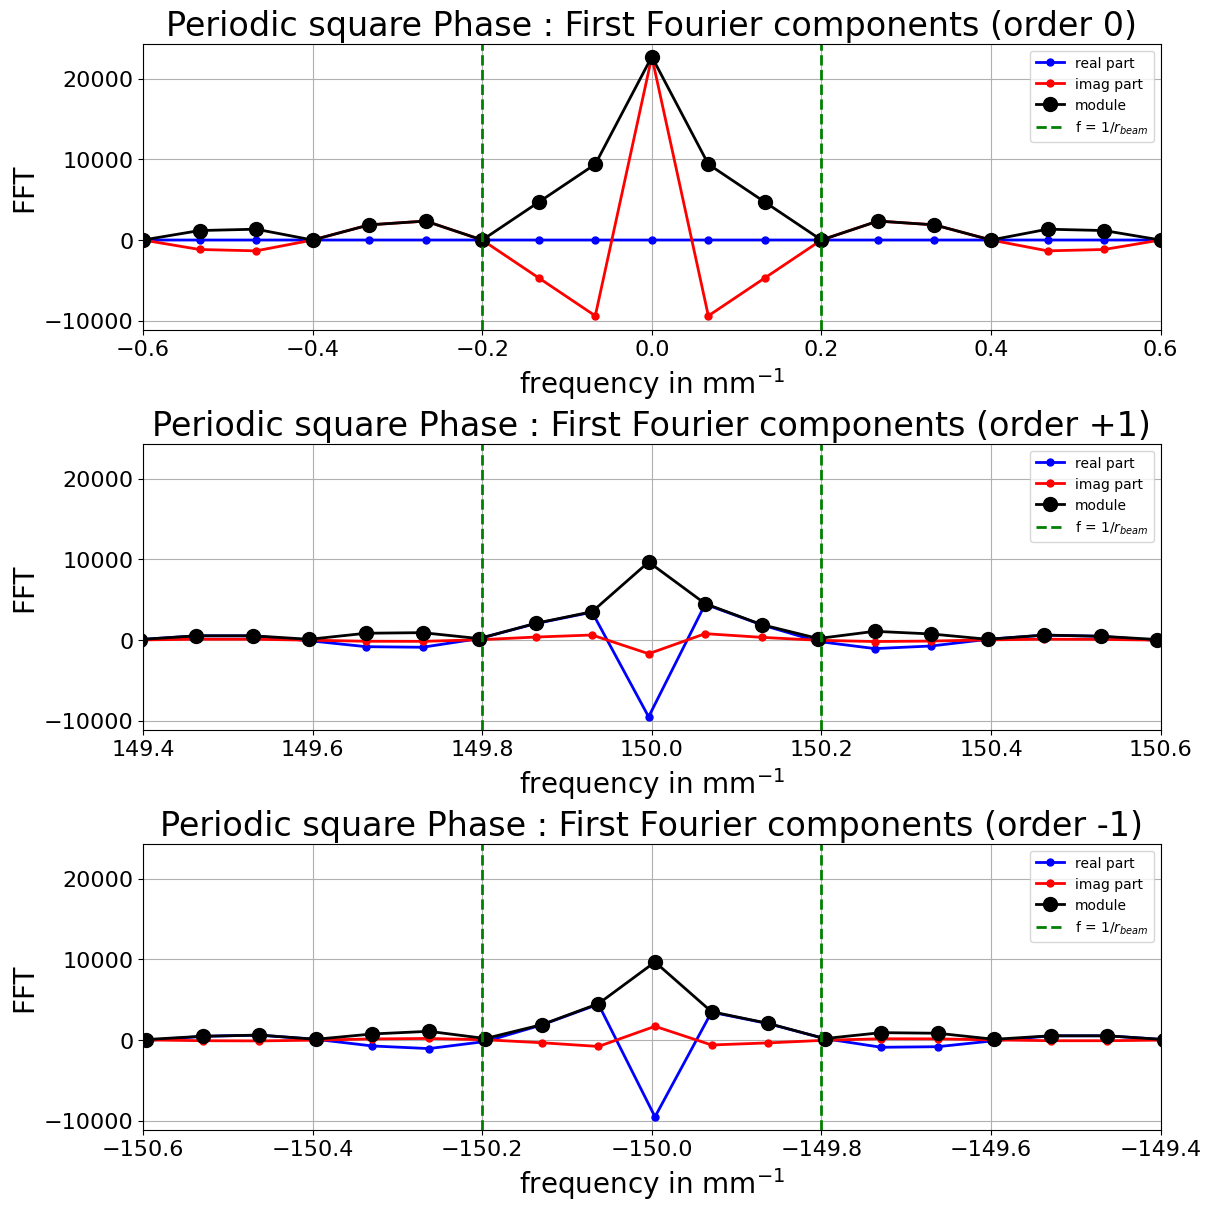

In [38]:
fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(12,12),layout="constrained")

DF = 3*1/beam_radius_mm

ax1.plot(freq,real,marker=".",c="b",label="real part")
ax1.plot(freq,imag,marker=".",c="r",label="imag part")
ax1.plot(freq,module,marker="o",c="k",label="module")
ax1.set_ylabel("FFT")
ax1.set_xlim(-DF,DF)

ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.axvline(x=1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax1.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax1.grid()
ax1.legend()
ax1.set_title("Periodic square Phase : First Fourier components (order 0)")


ax2.plot(freq,real,marker=".",c="b",label="real part")
ax2.plot(freq,imag,marker=".",c="r",label="imag part")
ax2.plot(freq,module,marker="o",c="k",label="module")
ax2.set_ylabel("FFT")
ax2.set_xlim( f_order1 -DF , f_order1+ DF)

ax2.set_xlabel("frequency in mm$^{-1}$")
ax2.axvline(x=f_order1 + 1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax2.axvline(x=f_order1 -1/beam_radius_mm,c="g",ls="--")
ax2.grid()
ax2.legend()
ax2.set_title("Periodic square Phase : First Fourier components (order +1)")


ax3.plot(freq,real,marker=".",c="b",label="real part")
ax3.plot(freq,imag,marker=".",c="r",label="imag part")
ax3.plot(freq,module,marker="o",c="k",label="module")
ax3.set_ylabel("FFT")
ax3.set_xlim( -f_order1 -DF , -f_order1+ DF)

ax3.set_xlabel("frequency in mm$^{-1}$")
ax3.axvline(x=-f_order1 + 1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax3.axvline(x=-f_order1 -1/beam_radius_mm,c="g",ls="--")
ax3.grid()
ax3.legend()
ax3.set_title("Periodic square Phase : First Fourier components (order -1)")



## FFT components 

In [40]:
DF = 5*1/beam_radius_mm
indexes_order_0 = np.where(np.abs(freq)<DF)[0]
indexes_order_p1 = np.where(np.abs(freq-f_order1)<DF)[0]
indexes_order_m1 = np.where(np.abs(freq+f_order1)<DF)[0]


Text(0.5, 0.98, 'Coefficients of FFT around order 0')

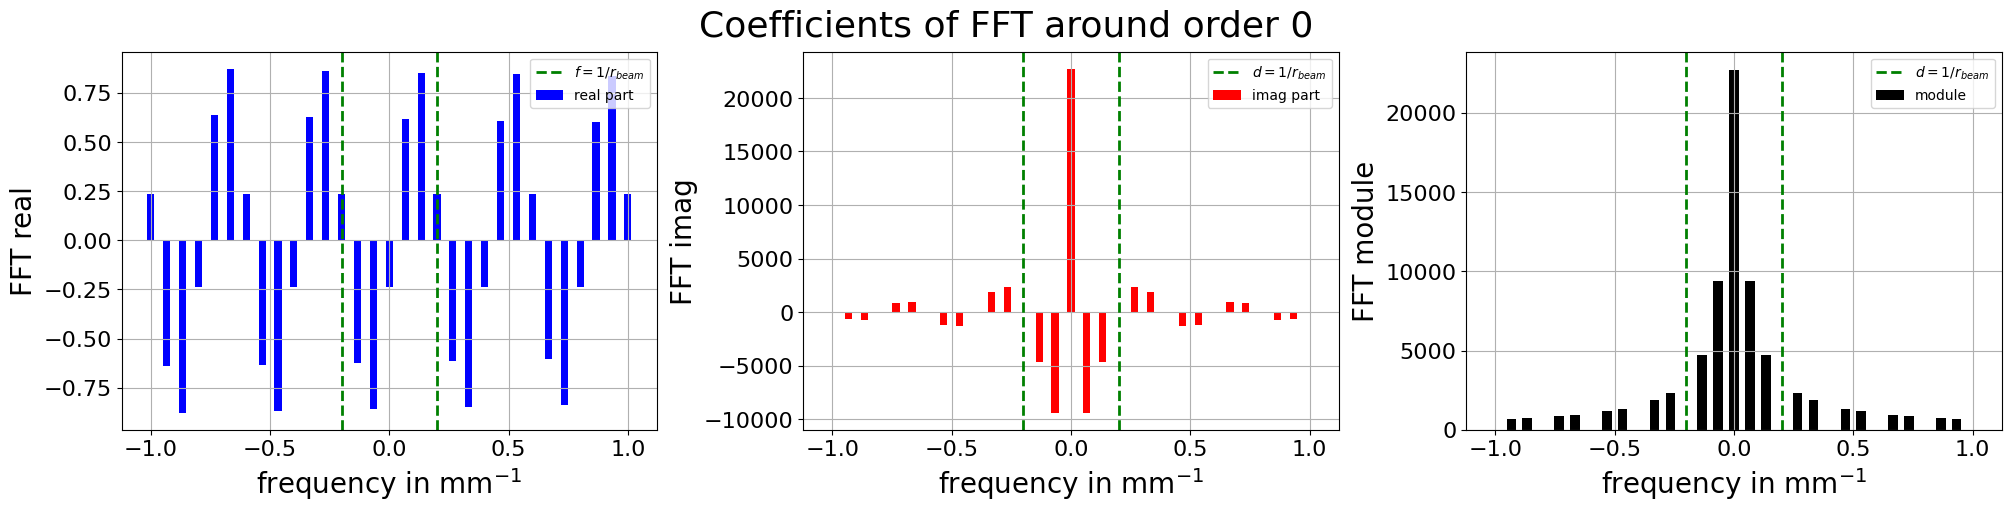

In [41]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_0],real[indexes_order_0],width=0.03,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_0],imag[indexes_order_0],width=0.03,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_0],module[indexes_order_0],width=0.04,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/beam_radius_mm  ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm  ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm  ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm  ,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm  ,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm  ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle("Coefficients of FFT around order 0",fontsize=26)


Text(0.5, 0.98, 'Coefficients of FFT around order 1')

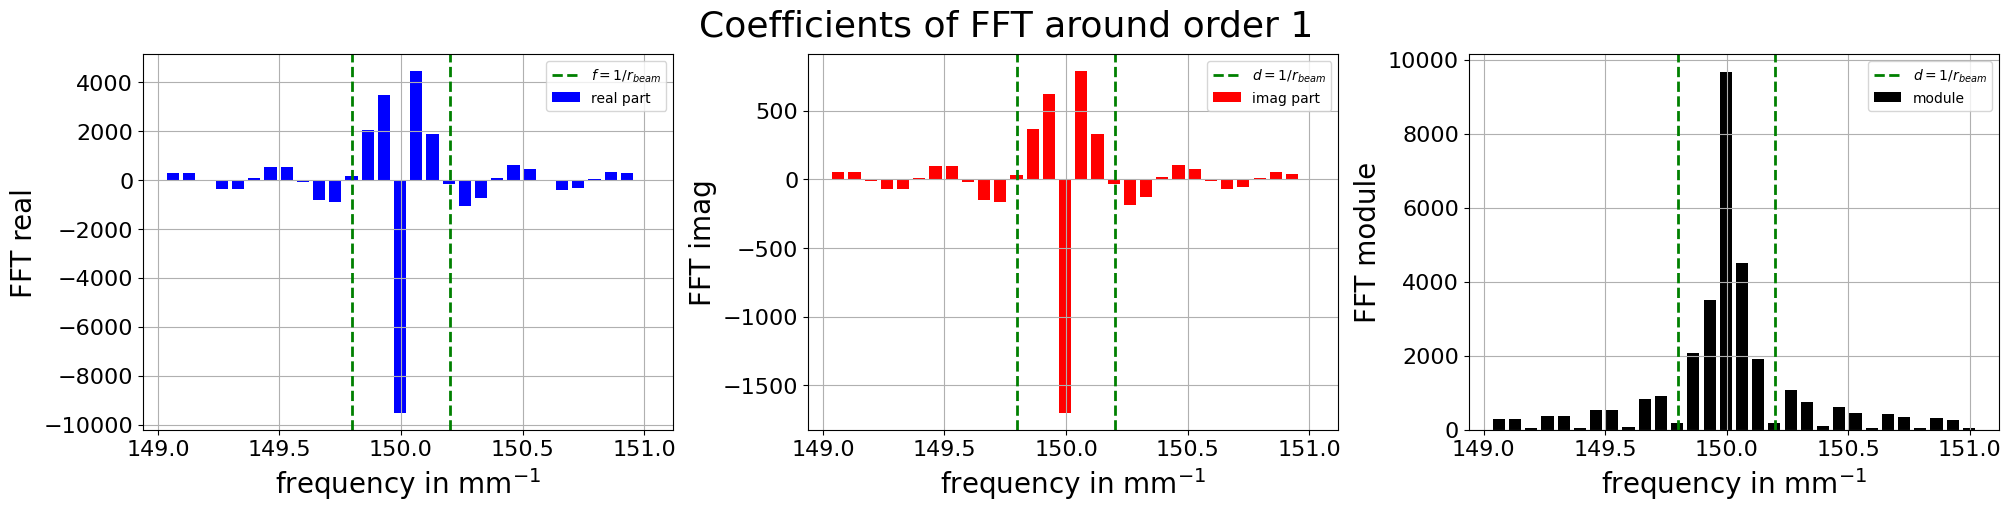

In [65]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_p1],real[indexes_order_p1],width=0.05,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_p1],imag[indexes_order_p1],width=0.05,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_p1],module[indexes_order_p1],width=0.05,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/beam_radius_mm + f_order1 ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm + f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm + f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm + f_order1 ,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm + f_order1 ,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm + f_order1 ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle("Coefficients of FFT around order 1",fontsize=26)

Text(0.5, 0.98, 'Coefficients of FFT around order -1')

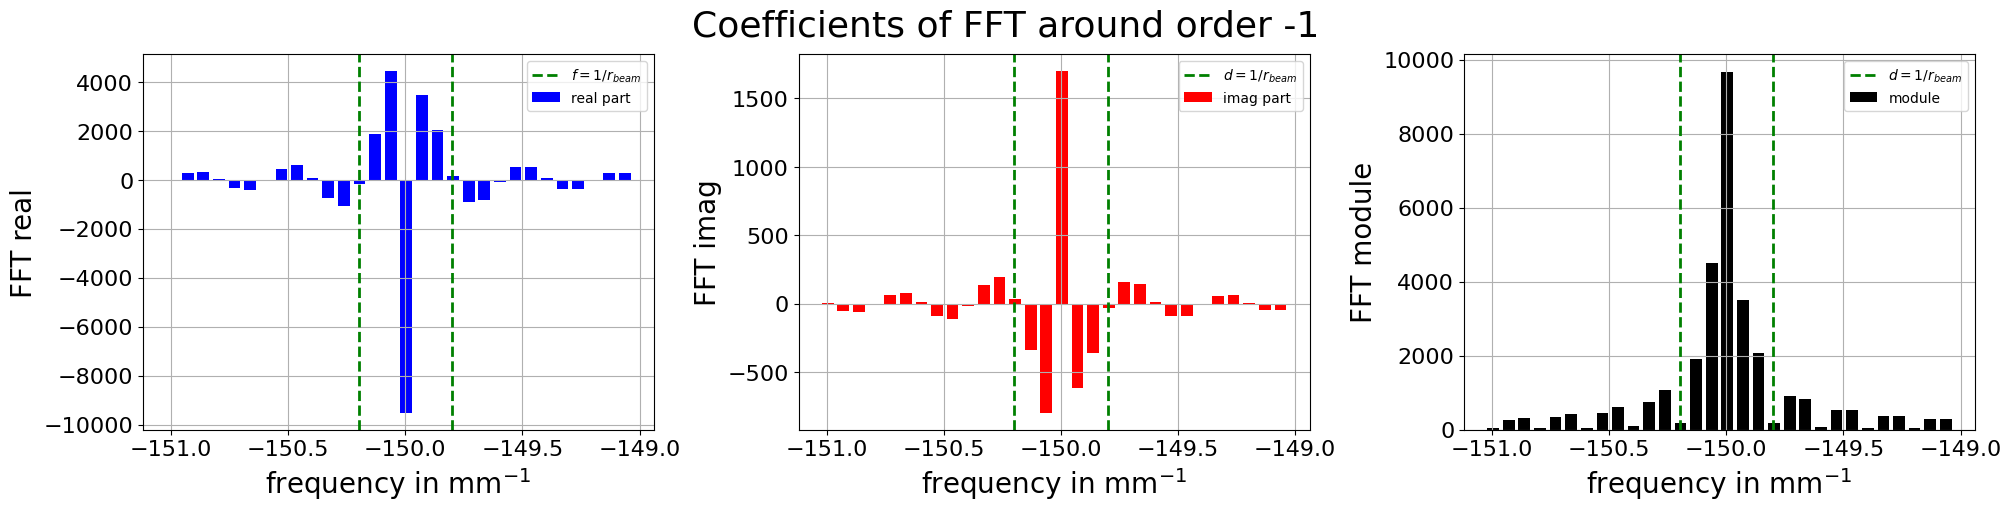

In [43]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_m1],real[indexes_order_m1],width=0.05,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_m1],imag[indexes_order_m1],width=0.05,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_m1],module[indexes_order_m1],width=0.05,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/beam_radius_mm - f_order1 ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm - f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm - f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm - f_order1 ,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm - f_order1 ,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm - f_order1 ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle("Coefficients of FFT around order -1",fontsize=26)

## Transmission efficiency

In [44]:
w_factor = 5.

In [45]:
indexesa_order_0 = np.where(np.abs(freqa)<w_factor /beam_radius_mm)[0]

In [46]:
indexes_order_0 = np.where(np.abs(freq)<w_factor/beam_radius_mm)[0]
indexes_order_p1 = np.where(np.abs(freq-f_order1)<w_factor /beam_radius_mm)[0]
indexes_order_m1 = np.where(np.abs(freq+f_order1)<w_factor /beam_radius_mm)[0]

In [47]:
# only beam aperture
coeffa_order_0 = modulea[indexesa_order_0]
# beam aperture + holo phase HOE
coeff_order_0 = module[indexes_order_0]
coeff_order_p1 = module[indexes_order_p1]
coeff_order_m1 = module[indexes_order_m1]

In [48]:
efficiency_orderp1 = (coeff_order_p1**2).sum()/(coeffa_order_0**2).sum()
efficiency_orderm1 = (coeff_order_m1**2).sum()/(coeffa_order_0**2).sum()

In [49]:
print(f"Transmission efficiency of order 1 : {efficiency_orderp1:.4f}")
print(f"Transmission efficiency of order -1 : {efficiency_orderm1:.4f}")

Transmission efficiency of order 1 : 0.1319
Transmission efficiency of order -1 : 0.1319


In [50]:
orderp1order0 = (coeff_order_p1**2).sum()/(coeff_order_0**2).sum()
orderm1order0 = (coeff_order_m1**2).sum()/(coeff_order_0**2).sum()

In [51]:
print(f"Transmission radio order +1/ order 0 : {orderp1order0:.4f}")
print(f"Transmission radio order -1/ order 0 : {orderm1order0:.4f}")

Transmission radio order +1/ order 0 : 0.1819
Transmission radio order -1/ order 0 : 0.1819


## Compute Fourier coefficients

- CHECK Complex Fourier Series

- For $n=0$

$$
a_0 = \frac{1}{a} \int_{-a/2}^{a/2} t(x) dx
$$

- For $|n| >=1$ :
$$
a_n = \frac{1}{a} \int_{-a/2}^{a/2} t(x) \cos(2\pi n \frac{x}{a}) dx
$$
$$
b_n = \frac{1}{a} \int_{-a/2}^{a/2} t(x) \sin(2\pi n \frac{x}{a}) dx
$$
$$
c_n = \frac{1}{a} \int_{-a/2}^{a/2} t(x) \exp(i2\pi n \frac{x}{a}) dx
$$

In [52]:
## Multiply by the phase function
def integrand_an(x, n):
    return np.cos(2*np.pi*n*x/a)*set_holo_phase_debug(x,opticalelement_nblines_permm=Neff,xshift=0)/a
def integrand_bn(x, n):
    return np.sin(2*np.pi*n*x/a)*set_holo_phase_debug(x,opticalelement_nblines_permm=Neff,xshift=0)/a
def integrand_cn(x, n):
    return np.exp(2j*np.pi*n*x/a)*set_holo_phase_debug(x,opticalelement_nblines_permm=Neff,xshift=0)/a

### Compute Fourier coefficients

#### Order zero coefficients

In [53]:
a0_v0 = quad(integrand_an, -a/2, a/2, args=(0,))
b0_v0 = quad(integrand_bn, -a/2, a/2, args=(0,))
c0_v0 = quad(integrand_cn, -a/2, a/2, args=(0,))
# transform tuples from quad function in  complex numbers
a0_v1 = a0_v0[0] + 1j* a0_v0[1]
b0_v1 = b0_v0[0] + 1j* b0_v0[1]
c0_v1 = c0_v0[0] + 1j* c0_v0[1]

/Users/dagoret/anaconda3/envs/poppy_py312/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


In [54]:
print(f"v0 : (a0,b0,c0) = (",a0_v0,b0_v0,c0_v0,")")
print(f"v1 : (a0,b0,c0) = ({a0_v1:.4f},{b0_v1:.4f}, {c0_v1:.4f})")

v0 : (a0,b0,c0) = ( (3.057595593113572e-19, 5.154347949972923e-15) (0.0, 0.0) (3.057595593113572e-19, 5.154347949972923e-15) )
v1 : (a0,b0,c0) = (0.0000+0.0000j,0.0000+0.0000j, 0.0000+0.0000j)


#### Order 1 coefficients

In [55]:
a1_v0 = quad(integrand_an, -a/2, a/2, args=(1,))
b1_v0 = quad(integrand_bn, -a/2, a/2, args=(1,))
c1_v0 = quad(integrand_cn, -a/2, a/2, args=(1,))

# transform tuples in  complex numbers
a1_v1 = a1_v0[0] + 1j* a1_v0[1]
b1_v1 = b1_v0[0] + 1j* b1_v0[1]
c1_v1 = c1_v0[0] + 1j* c1_v0[1]

In [56]:
# compare tuple from quad function and redefined single complex number
print(f"v0 : (a1,b1,c1) = (",a1_v0,b1_v0,c1_v0,")")
print(f"v1 : (a1,b1,c1) = ({a1_v1:.4f},{b1_v1:.4f},{c1_v1:.4f})")

v0 : (a1,b1,c1) = ( (-0.36318783834686735, 1.3326691586748075e-10) (0.0, 2.628487966738954e-15) (-0.3631878383468673, 1.2555021550121528e-10) )
v1 : (a1,b1,c1) = (-0.3632+0.0000j,0.0000+0.0000j,-0.3632+0.0000j)


#### Other Orders n>=2 coefficients

In [57]:
sum_supp2_v1_ab = 0
sum_supp2_v1_c = 0
for n in range(2,300):
    an = quad(integrand_an, -a/2, a/2, args=(n,))
    bn = quad(integrand_bn, -a/2, a/2, args=(n,))
    cn = quad(integrand_cn, -a/2, a/2, args=(n,))
    
    # convert tuple into complex number
    an_v1 = an[0]+ 1j*an[1]
    bn_v1 = bn[0]+ 1j*bn[1]
    cn_v1 = cn[0]+ 1j*cn[1]
    
    if n==2 or n%10 == 1 or n%10 == 0:
        print(f"n = {n} :: cn = {cn_v1:.4f}")
    
    sum_supp2_v1_ab += np.absolute(an_v1)**2 + np.absolute(bn_v1)**2 
    sum_supp2_v1_c += np.absolute(cn_v1)**2 
    
    if n%10 == 1 or n%10 == 0:
        print(f"n = {n} :: cn = {cn_v1:.4f}   ==> sum^2 = {sum_supp2_v1_c} ")
    
print(sum_supp2_v1_ab,sum_supp2_v1_c)

n = 2 :: cn = 0.0000+0.0000j
n = 10 :: cn = 0.0000+0.0000j
n = 10 :: cn = 0.0000+0.0000j   ==> sum^2 = 9.429013487107189e-05 
n = 11 :: cn = 0.0000+0.0000j
n = 11 :: cn = 0.0000+0.0000j   ==> sum^2 = 9.429013487107189e-05 
n = 20 :: cn = -0.0000+0.0000j
n = 20 :: cn = -0.0000+0.0000j   ==> sum^2 = 9.429013487122715e-05 
n = 21 :: cn = -0.0000+0.0000j
n = 21 :: cn = -0.0000+0.0000j   ==> sum^2 = 9.429013487131729e-05 
n = 30 :: cn = -0.0000+0.0000j
n = 30 :: cn = -0.0000+0.0000j   ==> sum^2 = 9.429013487131729e-05 
n = 31 :: cn = 0.0000+0.0000j
n = 31 :: cn = 0.0000+0.0000j   ==> sum^2 = 9.429013487131737e-05 
n = 40 :: cn = -0.0000+0.0000j
n = 40 :: cn = -0.0000+0.0000j   ==> sum^2 = 9.429013487172965e-05 
n = 41 :: cn = -0.0000+0.0000j
n = 41 :: cn = -0.0000+0.0000j   ==> sum^2 = 9.429013487188373e-05 
n = 50 :: cn = -0.0000+0.0000j
n = 50 :: cn = -0.0000+0.0000j   ==> sum^2 = 9.429013487196716e-05 
n = 51 :: cn = 0.0000+0.0000j
n = 51 :: cn = 0.0000+0.0000j   ==> sum^2 = 9.4290134871

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_78975/2232835117.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  cn = quad(integrand_cn, -a/2, a/2, args=(n,))
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_78975/2232835117.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from sp

n = 100 :: cn = 0.0000+0.0000j
n = 100 :: cn = 0.0000+0.0000j   ==> sum^2 = 9.429048112448882e-05 
n = 101 :: cn = 0.0000+0.0000j
n = 101 :: cn = 0.0000+0.0000j   ==> sum^2 = 9.429090343957479e-05 
n = 110 :: cn = -0.0000+0.0000j
n = 110 :: cn = -0.0000+0.0000j   ==> sum^2 = 0.05917631898060384 
n = 111 :: cn = 0.0000+0.0001j
n = 111 :: cn = 0.0000+0.0001j   ==> sum^2 = 0.05917633027995059 
n = 120 :: cn = -0.0000+0.0000j
n = 120 :: cn = -0.0000+0.0000j   ==> sum^2 = 0.05918082439835158 
n = 121 :: cn = -0.0000+0.0025j
n = 121 :: cn = -0.0000+0.0025j   ==> sum^2 = 0.0591872487255916 


/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_78975/2232835117.py:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  an = quad(integrand_an, -a/2, a/2, args=(n,))
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_78975/2232835117.py:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  cn = quad(integrand_cn, -a/2, a/2, args=(n,))


n = 130 :: cn = -0.0000+0.0000j
n = 130 :: cn = -0.0000+0.0000j   ==> sum^2 = 0.5646608285584099 
n = 131 :: cn = 0.0000+1.4024j
n = 131 :: cn = 0.0000+1.4024j   ==> sum^2 = 2.5313794622075854 
n = 140 :: cn = 0.0000+0.0000j
n = 140 :: cn = 0.0000+0.0000j   ==> sum^2 = 2.5410403915846707 
n = 141 :: cn = -0.0000+0.0347j
n = 141 :: cn = -0.0000+0.0347j   ==> sum^2 = 2.542245849650486 
n = 150 :: cn = -0.0000+0.0000j
n = 150 :: cn = -0.0000+0.0000j   ==> sum^2 = 3.012217924075238 
n = 151 :: cn = -0.0000+0.2012j
n = 151 :: cn = -0.0000+0.2012j   ==> sum^2 = 3.0527035494433443 
n = 160 :: cn = -0.0000+0.0000j
n = 160 :: cn = -0.0000+0.0000j   ==> sum^2 = 3.1729346498246915 
n = 161 :: cn = -0.0000+0.0255j
n = 161 :: cn = -0.0000+0.0255j   ==> sum^2 = 3.173584713242799 
n = 170 :: cn = -0.0000+0.0000j
n = 170 :: cn = -0.0000+0.0000j   ==> sum^2 = 3.449994658703113 
n = 171 :: cn = 0.0000+0.0412j
n = 171 :: cn = 0.0000+0.0412j   ==> sum^2 = 3.451690793547722 
n = 180 :: cn = 0.0000+0.0000j


### Transmission efficiency and order ratio

#### Efficienc

In [58]:
efficiency_order0_v1 = np.absolute(c0_v1)**2/(np.absolute(c0_v1)**2 + 2*(np.absolute(c1_v1))**2 + 2*sum_supp2_v1_c)
efficiency_orderp1_v1 = np.absolute(c1_v1)**2/(np.absolute(c0_v1)**2 + 2*(np.absolute(c1_v1))**2 + 2*sum_supp2_v1_c)
efficiency_orderm1_v1 =  np.absolute(c1_v1)**2/(np.absolute(c0_v1)**2 + 2*(np.absolute(c1_v1))**2 + 2*sum_supp2_v1_c)

In [59]:
print(f"Fourier Coeff : v1 : Transmission efficiency of order 0 : {efficiency_order0_v1:.4f}")
print(f"Fourier Coeff : v1 : Transmission efficiency of order 1 : {efficiency_orderp1_v1:.4f}")
print(f"Fourier Coeff : v1 : Transmission efficiency of order -1 : {efficiency_orderm1_v1:.4f}")

Fourier Coeff : v1 : Transmission efficiency of order 0 : 0.0000
Fourier Coeff : v1 : Transmission efficiency of order 1 : 0.0069
Fourier Coeff : v1 : Transmission efficiency of order -1 : 0.0069


#### Order ratio

In [60]:
orderp1order0_v1 = np.absolute(c1_v1)**2/np.absolute(c0_v1)**2
orderm1order0_v1 = np.absolute(c1_v1)**2/np.absolute(c0_v1)**2

In [61]:
print(f"Fourier Coeff : v1 : Transmission radio order +1/ order 0 : {orderp1order0_v1:.4f}")
print(f"Fourier Coeff : v1 : Transmission radio order -1/ order 0 : {orderm1order0_v1:.4f}")

Fourier Coeff : v1 : Transmission radio order +1/ order 0 : 4964952840887558672385835008.0000
Fourier Coeff : v1 : Transmission radio order -1/ order 0 : 4964952840887558672385835008.0000
